# Practicing Advanced Feedback Control

In this unit we are going to explore basic feedback control on a simplified, 1-dimensional model of the quadrotor-camera. This system is more complicated than the Simple Slide Camera model because it incorporates a dependency between the velocity and a pitch angle as well as a dependency of the output angle, $\gamma$, on the pitch angle, $\theta$.

## Pitch Slide Camera

Imagine a camera attached to a cart that is allowed to slide along a 1-dimensional track. The track is elevated some height $h$ above the ground and the camera is pitched at an angle $\theta$ relative to vertical. There is some target on the ground that the camera can observe; more specifically the camera can measure the angle $-\pi /2 < \gamma < \pi/2$ from the centerline of the camera to the target. Since the view angle depends on the pitch of the camera, $\gamma$ is a function of pitch in the form:

$\gamma = -\left(\text{tan}^{-1}\left( \frac{x_{des}-x}{h}\right) + \theta \right) = \text{tan}^{-1}\left( \frac{x - x_{des}}{h}\right) - \theta$

Note that orientation of $\gamma$ (i.e. the minus sign at the beginning of the expression) is by convention.

The velocity of camera-cart system is also dependent upon the pitch angle; i.e. the larger the pitch, the greater the change in velocity (you could think of this somewhat similar to a segway scooter). The velocity dependence is defined by:

$\dot{v} = K \text{sin}(\theta)$

The objective is to issue pitch commands commands, $\theta_{cmd}$, in order to move the cart to a position such that $\gamma \rightarrow \gamma_{des}$ (e.g. if $\gamma_{des} = 0$, then the objective is simply to move the cart directly over the target.)

This system is depicted in the below diagram:

<img src="pitch_slide_camera.jpg">

This somewhat contrived system can be thought of as a simplified model of the quadrotor and it's downward-facing camera. 
The velocity of a quadrotor is in fact a function of the pitch of the quadrotor, similar to this system. The major simplification here is that the system is constrained to move in 1-dimension, which is not the case for a quadrotor.

Note that the position and velocity of the cart, $x$ and $v$, and position of the target $x_{des}$ are not directly measured, only $\gamma$ is measured.

Now we will provide the code necessary to simulate this system

In [3]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

_HEIGHT = 1.0
_VEL_CONST = 1.0
_TIME_STEP = 0.1
_THETA_LIMIT = np.pi/4.0

## Plant Dynamics, Sensors, and Actuators

the following object contains functions for the plant dynamics, sensing of the target angle $\gamma$, and actuator for $v_{cmd}$

In [35]:
class PitchSlideCamera():
    '''Object that defines the dynamics of the simple slide-camera'''
    
    def __init__(self, x_0, v_0, theta_0, x_d, gamma_d=0.0, h=_HEIGHT, k=_VEL_CONST, theta_limit=_THETA_LIMIT):
        
        # state variables (hidden)
        self.__x = x_0
        self.__v = v_0
        
        # reference position (hidden)
        self.__x_d = x_d
        
        # reference angle (observed)
        self.gamma_d = gamma_d
        
        # parameters
        self.__h = h
        self.__k = k
        self.__theta_limit = theta_limit
        
        # control variables (observed, commanded)
        self.__theta = theta_0
        
    def get_theta(self):
        return self.__theta
        
    def sense_gamma(self):
        # calculate angle from camera center line to target
        return  np.arctan2(self.__x - self.__x_d, self.__h) - self.__theta
    
    def _get_hidden_position(self):
        
        return self.__x
    
    def _get_hidden_position_desired(self):
        return self.__x_d
    
    def _get_hidden_velocity(self):
        return self.__v
    
    def actuate_theta_command(self, theta_cmd, dt=_TIME_STEP):
        self.__theta = min(self.__theta_limit, max(theta_cmd, -self.__theta_limit))
        self.__v += self.__k*np.sin(self.__theta)*dt
        self.__x += self.__v*dt 

## Controllers

Functions for control algorithms such as proportional control, proportional-derivative control, etc, as well as any custom controllers you may wish to try

In [36]:
def p_control(y_err, kp):
    ''' compute the actuator command based on proportional error between output and desired output
    Args:
    y_err: y - y_des where y is the output variable of the plant
    '''
    
    # TODO: write a proportional control law (hint: it is a single line, very simple equations)
    cmd = -kp*y_err
    # END TODO
    
    return cmd

In [90]:
def pd_control(y_err, y_err_prev, dt, kp, kd):
    '''compute the actuator command based on proportional and derivative error between output and target
    Args:
    y_err: y - y_des where y is the output variable of the plant
    y_err_prev: previous setp x - x_des
    '''
    cmd =- (kd*(y_err-y_err_prev)/dt+kp* y_err)
    return cmd

In [91]:
def pid_control(y_err ,y_err_prev, err_gamma_sum, dt, kp, kd, ki):
    '''custom-made controller, if you want to develop one
    Args:
    '''
    cmd =- (kd*(y_err-y_err_prev)/dt+ki*err_gamma_sum+kp* y_err)
    
    return cmd

## Simulation Script

below is a script for testing various controllers for the `SimpleSlideCamera` plant as well as plotting the results.

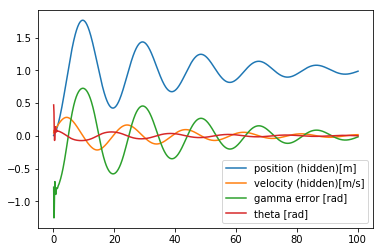

In [171]:
dt = _TIME_STEP
# Control inputs
kp = 0.1 # TODO: find an effective proportional gain
kd = 0.05 #TODO: find an effective derivative gain
ki= 0

t_final = 100.0

# intial conditions (position, velocity and targe position)
x_0 = 0.0
v_0 = 0.0
theta_0 = 0.0
x_des = 1.0

# create SimpleSlideCamera with initial conditions
pscam = PitchSlideCamera(x_0, v_0, theta_0, x_des)

# initialize data storage
data = dict()
data['t'] = []
data['theta_cmd'] = []
data['theta'] = []
data['err_gamma'] = []
data['x_hidden'] = []
data['v_hidden'] = []
t = 0.0
err_gamma_prev = 0.0
while t < t_final:
    t += dt
    
    # SENSOR: sense output variable gamma (angle from camera centerline to target) and calculate error from desired
    err_gamma = pscam.sense_gamma() - pscam.gamma_d
    
    # CONTROLLER: call theta control algoritm
    #theta_cmd = p_control(err_gamma, kp)
    #theta_cmd = pd_control(err_gamma, err_gamma_prev, dt, kp, kd)
    theta_cmd = pid_control(err_gamma, err_gamma_prev, sum(data['err_gamma']), dt, kp, kd, ki)
    
    # ACTUATOR: send velocity command to plant
    pscam.actuate_theta_command(theta_cmd)
    
    # store data
    err_gamma_prev = err_gamma
    data['t'].append(t)
    data['theta_cmd'].append(theta_cmd)
    data['theta'].append(pscam.get_theta())
    data['err_gamma'].append(err_gamma)
    data['x_hidden'].append(pscam._get_hidden_position())
    data['v_hidden'].append(pscam._get_hidden_velocity())
    
# Plot Data
handle_position, = plt.plot(data['t'], data['x_hidden'], label='position (hidden)[m]')
handle_velocity, = plt.plot(data['t'], data['v_hidden'], label='velocity (hidden)[m/s]')
handle_err_gamma, = plt.plot(data['t'], data['err_gamma'], label='gamma error [rad]')
handle_theta, = plt.plot(data['t'], data['theta'], label='theta [rad]')
plt.legend(handles=[handle_position, handle_velocity, handle_err_gamma, handle_theta])
plt.show()

## Questions

1. Can you design a controller that is capable of converging the gamma error to zero?